Data reading

In [138]:
import pandas as pd
file_path="/content/Credit Risk Benchmark Dataset.csv"
df=pd.read_csv(file_path)
print(df.head())

   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


Dataset evaluation

In [139]:
print(df.shape)

(16714, 11)


In [140]:
print(df.columns)

Index(['rev_util', 'age', 'late_30_59', 'debt_ratio', 'monthly_inc',
       'open_credit', 'late_90', 'real_estate', 'late_60_89', 'dependents',
       'dlq_2yrs'],
      dtype='object')


In [141]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB
None


In [142]:
print(df.describe())

           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890    719.694859    5931.841779   
min        0.000000     21.000000      0.000000      0.000000       0.000000   
25%        0.082397     38.000000      0.000000      0.155971    3128.500000   
50%        0.443080     48.000000      0.000000      0.322299    5000.000000   
75%        0.926637     58.000000      1.000000      0.533426    7573.000000   
max    22000.000000    101.000000     98.000000  61106.500000  250000.000000   

        open_credit       late_90   real_estate    late_60_89    dependents  \
count  16714.000000  16714.000000  16714.000000  16714.000000  16714.000000   
mean       8.503709      0.863827      1.047445      0.734354      0.944358   
std        5.370965      7.167576      1.2

Taking target variable and features

In [143]:
X = df.drop(['dlq_2yrs'], axis=1)
y=df['dlq_2yrs']

In [144]:
print("\nClass distribution of the target variable:")
print(y.value_counts())


Class distribution of the target variable:
dlq_2yrs
0    8357
1    8357
Name: count, dtype: int64


Data Visualization

boxplot

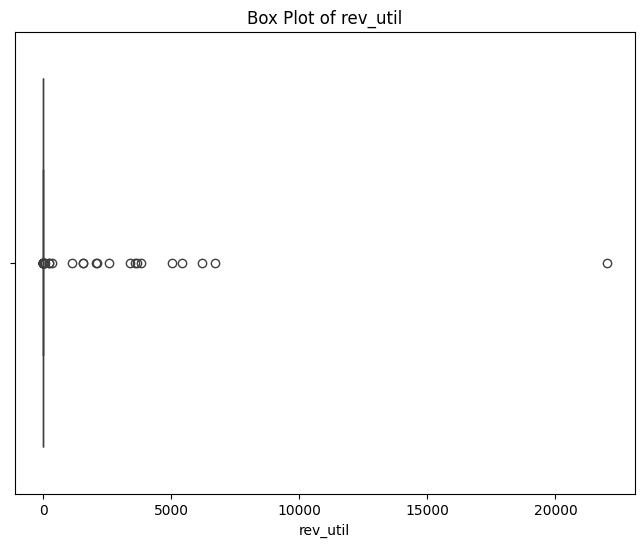

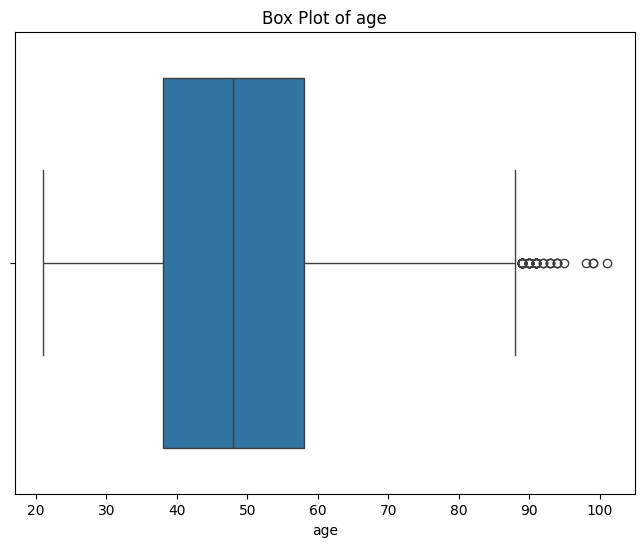

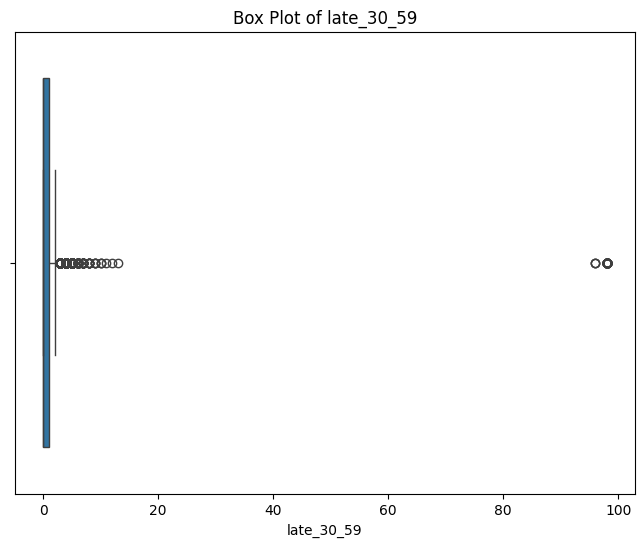

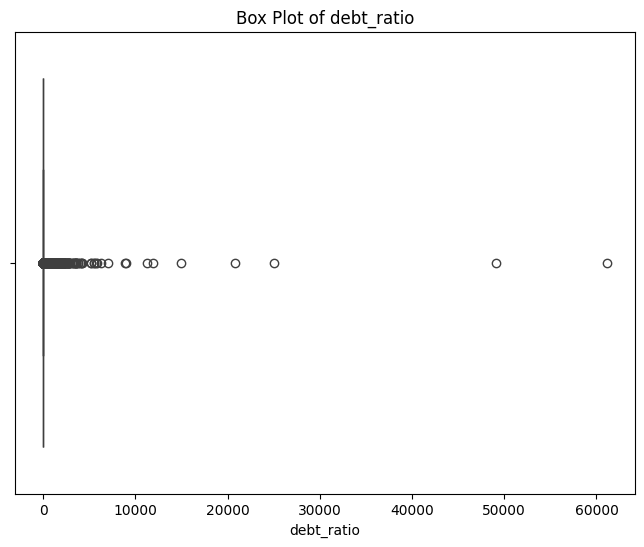

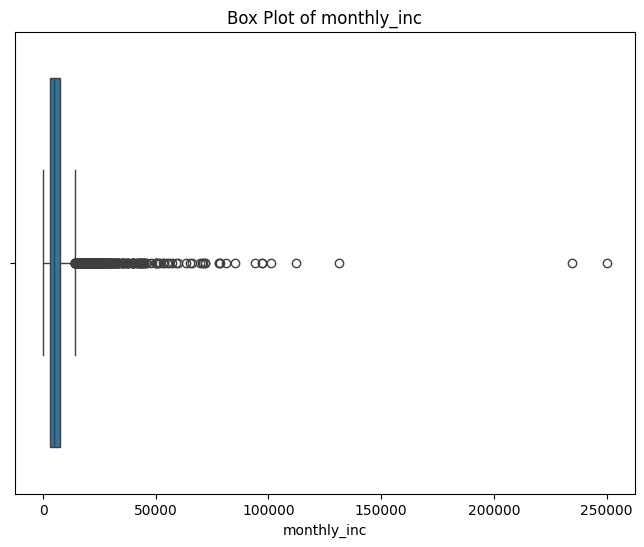

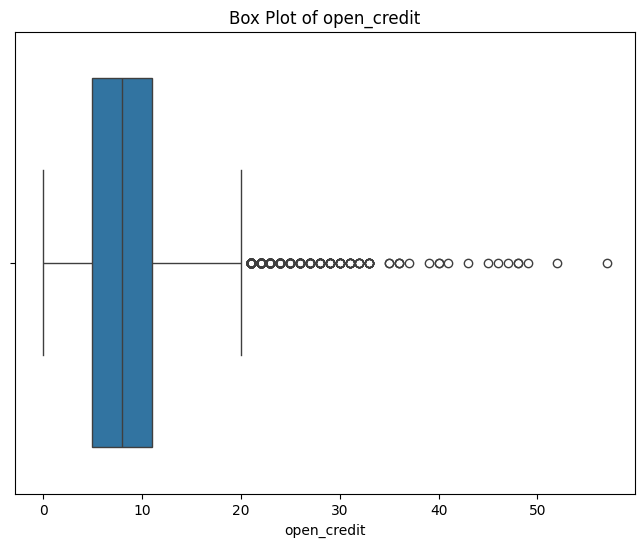

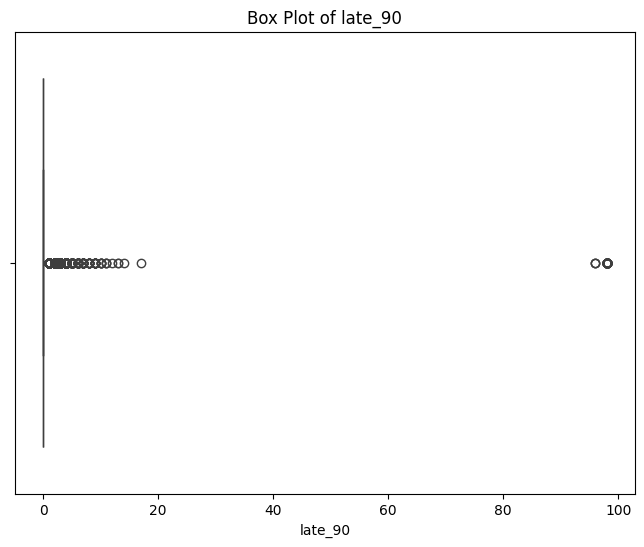

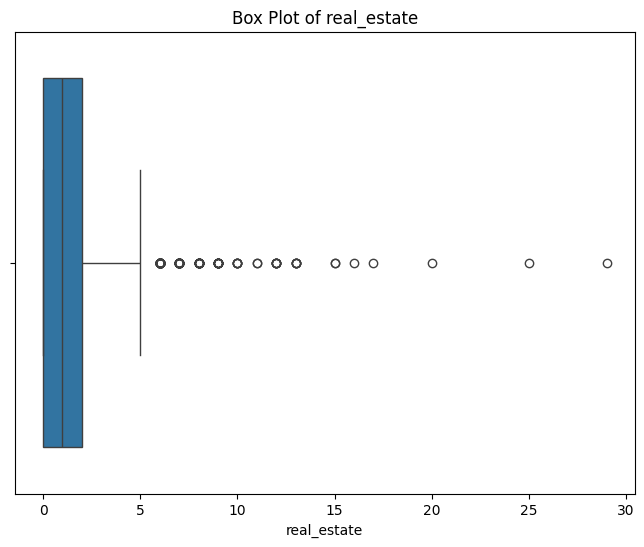

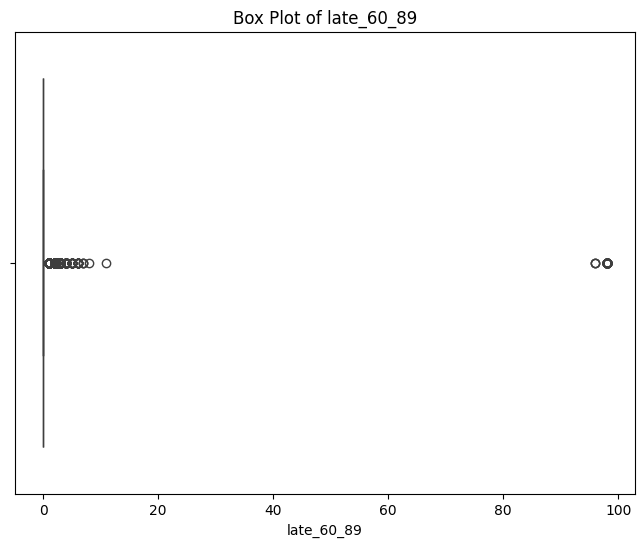

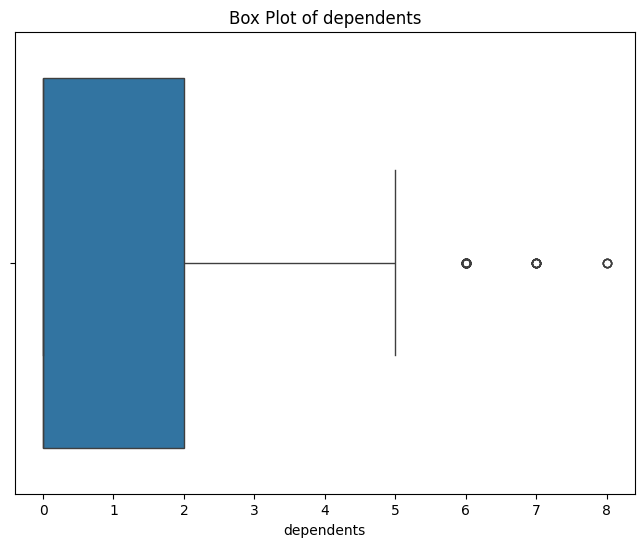

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
for col in X.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=X[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

feature importance

In [146]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
feature_importances = model.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=X.columns)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
print("\nFeature Importances:")
sorted_feature_importances


Feature Importances:


,0
rev_util,0.257811
debt_ratio,0.137093
monthly_inc,0.127432
age,0.112383
late_30_59,0.087195
open_credit,0.081149
late_90,0.080577
late_60_89,0.044928
dependents,0.036646
real_estate,0.034786


Removing outliers

In [147]:
import numpy as np

X = pd.DataFrame(X)

original_index = X.index
outlier_indices = set()

for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    outlier_indices.update(outliers.index)
y = pd.Series(y, index=original_index)

safe_indices = [idx for idx in outlier_indices if y[idx] != 1]

X_cleaned = X.drop(index=safe_indices)
y_cleaned = y.drop(index=safe_indices)

print("New dataset shape after outlier removal:", X_cleaned.shape, y_cleaned.shape)
print("Class distribution after outlier removal:\n", y_cleaned.value_counts())

New dataset shape after outlier removal: (15069, 10) (15069,)
Class distribution after outlier removal:
 dlq_2yrs
1    8357
0    6712
Name: count, dtype: int64


In [148]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)
# Check class distribution after SMOTE
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 8357, 1: 8357})


Pre Processing

In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [150]:
print(X_train.shape,y_train.shape)

(13371, 10) (13371,)


SVM model

In [151]:
#svm
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy using SVM:", accuracy)

Accuracy using SVM: 0.7816332635357464


In [152]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1669
           1       0.89      0.64      0.75      1674

    accuracy                           0.78      3343
   macro avg       0.80      0.78      0.78      3343
weighted avg       0.81      0.78      0.78      3343



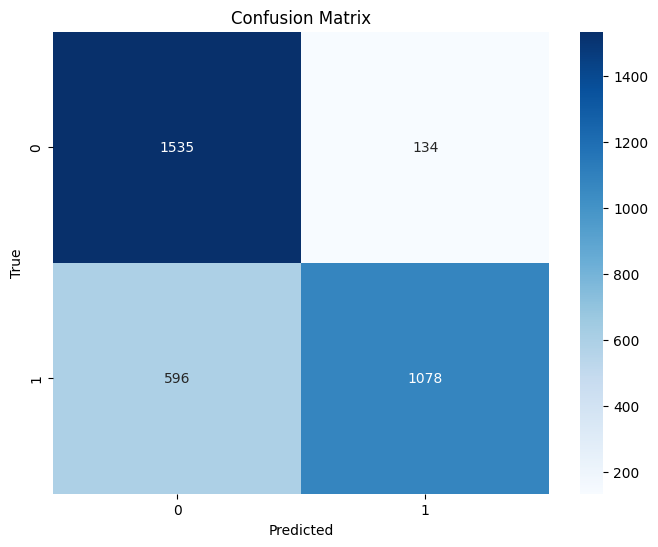

In [153]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Random Forest

In [154]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy using Random Forest:", accuracy_rf)


Accuracy using Random Forest: 0.8276996709542327


In [155]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1669
           1       0.86      0.78      0.82      1674

    accuracy                           0.83      3343
   macro avg       0.83      0.83      0.83      3343
weighted avg       0.83      0.83      0.83      3343



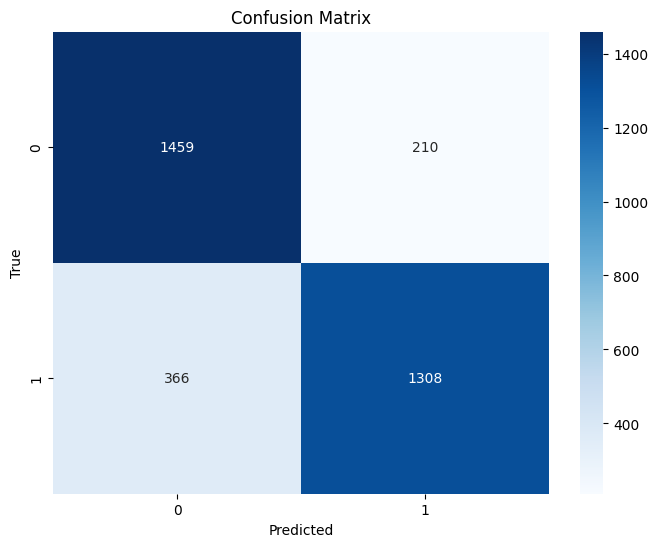

In [156]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

XGBClassifier model

In [157]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)


# Train model
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8262040083757104


In [158]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1669
           1       0.86      0.78      0.82      1674

    accuracy                           0.83      3343
   macro avg       0.83      0.83      0.83      3343
weighted avg       0.83      0.83      0.83      3343



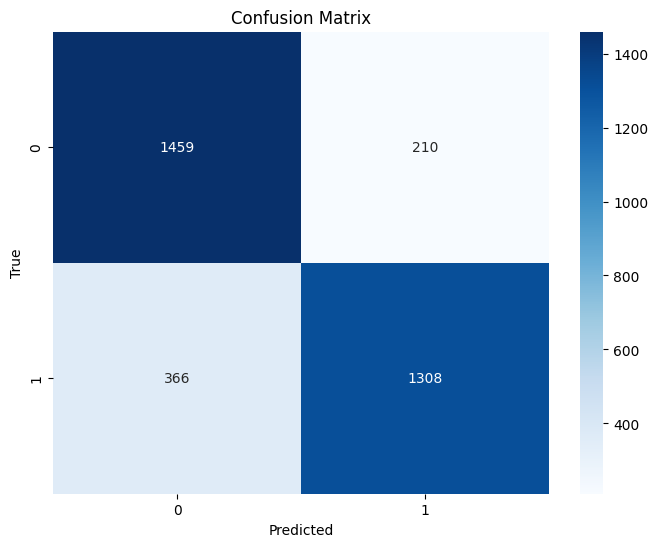

In [159]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

LGBMClassifier model

In [160]:
from lightgbm import LGBMClassifier
lgbmc_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Train
lgbmc_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lgbmc_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.825306610828597


In [161]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1669
           1       0.86      0.78      0.82      1674

    accuracy                           0.83      3343
   macro avg       0.83      0.83      0.83      3343
weighted avg       0.83      0.83      0.83      3343



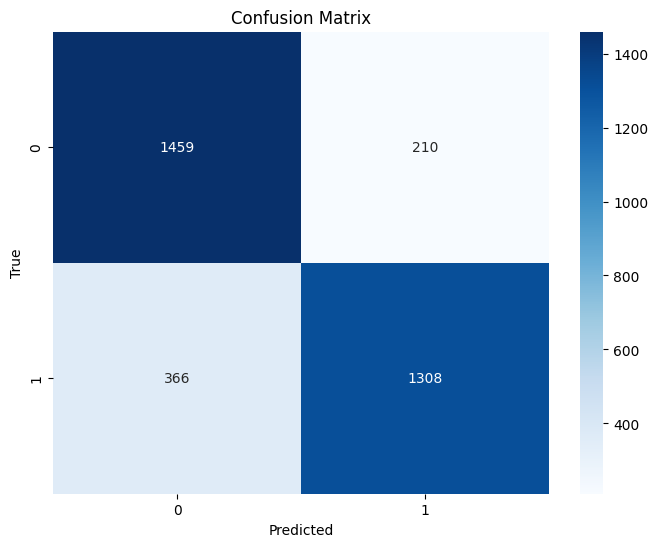

In [162]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [163]:
import pickle
filename = 'model.pkl'
pickle.dump(lgbmc_model, open(filename, 'wb'))